In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
# from sklearn.preprocessing import MinMaxScaler THIS COMMENT IS FOR TESTING PUSH IN KAGGLE(USING BUTTON CUZ THERE IS NO OTHER WAY PERHAPS)

In [2]:
# Run before importing torch. This is for cuda memory allocation error. Doesn't fix it tho.
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# For Colab
from google.colab import drive
drive.mount('/content/drive')
sys.path.append("/content/drive/MyDrive/Diplom/")

In [ ]:
# For Colab
df = pd.read_csv("/content/drive/MyDrive/Diplom/data/close_adjusted_17.csv")

In [5]:
# For Kaggle
df = pd.read_csv("/kaggle/input/stock-prices/data/close_adjusted_17.csv")

Cleaning dataframe.

In [6]:
# Convert 'date' to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Set 'date' as index
df.set_index("date", inplace=True)

#Getting rid of missing values
df = df.ffill().bfill()

In [7]:
df.shape

(4378, 505)

In [8]:
# Train Data: 2006-2017
train_prices = df.loc[:'2017']

# Validation Data: 2018
val_prices = df.loc['2018']

# Test Data: 2019 onward
test_prices = df.loc['2019':]

In [9]:
train_returns = ((train_prices - train_prices.shift(1)) / train_prices.shift(1)).iloc[1:]
val_returns = ((val_prices - val_prices.shift(1)) / val_prices.shift(1)).iloc[1:]
test_returns = ((test_prices - test_prices.shift(1)) / test_prices.shift(1)).iloc[1:]

In [10]:
train_prices.shape, val_prices.shape, test_prices.shape

((3019, 505), (251, 505), (1108, 505))

In [11]:
train_returns.shape, val_returns.shape, test_returns.shape

((3018, 505), (250, 505), (1107, 505))

In [12]:
train_returns.describe()

,CSCO.close,UAL.close,TROW.close,ISRG.close,PRGO.close,TPR.close,DVN.close,MRO.close,BA.close,VRTX.close,...,TSS.close,CRM.close,PGR.close,WAT.close,BWA.close,LRCX.close,NWL.close,UAA.close,BLK.close,PPL.close
count,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,...,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000
mean,0.000485,0.001095,0.000724,0.001055,0.000807,0.000468,0.000205,0.000399,0.000720,0.001051,...,0.000607,0.001160,0.000498,0.000702,0.000720,0.000830,0.000417,0.000894,0.000862,0.000306
std,0.018361,0.043495,0.023482,0.025874,0.020220,0.024315,0.025126,0.027014,0.017455,0.032835,...,0.017248,0.026764,0.017207,0.017925,0.024140,0.023793,0.021565,0.030767,0.022711,0.014213
min,-0.162109,-0.367709,-0.179387,-0.172167,-0.211412,-0.185706,-0.166888,-0.195645,-0.089290,-0.166782,...,-0.147391,-0.184533,-0.130179,-0.200055,-0.136625,-0.146129,-0.273147,-0.257429,-0.155242,-0.131840
25%,-0.007253,-0.016508,-0.008911,-0.009461,-0.008821,-0.010933,-0.012409,-0.012472,-0.008048,-0.014017,...,-0.006953,-0.011650,-0.007035,-0.007042,-0.010358,-0.011577,-0.008430,-0.013939,-0.008698,-0.006395
50%,0.000454,0.000000,0.000373,0.000420,0.000972,0.000343,0.000000,0.000566,0.001012,-0.000686,...,0.000743,0.000206,0.000434,0.000725,0.000470,0.000787,0.000330,0.000879,0.000306,0.000799
75%,0.008605,0.018270,0.009733,0.010863,0.010798,0.011278,0.013070,0.013846,0.009534,0.014913,...,0.008583,0.013232,0.007974,0.008612,0.011899,0.013214,0.009296,0.015506,0.010610,0.007459
max,0.159501,0.685371,0.181666,0.323227,0.183899,0.204482,0.214667,0.233562,0.154628,0.619066,...,0.131648,0.191308,0.239742,0.162599,0.228278,0.151911,0.205310,0.263383,0.195609,0.148006


Dataloader construction.

In [13]:
class StockDataset(Dataset):
    def __init__(self, returns_df, prices_df, window_size=100, sharpe_window=10):
        """
        returns_df: pandas DataFrame (days, 505) - daily returns
        prices_df: pandas DataFrame (days, 505) - daily prices
        window_size: T (sequence length for LSTM)
        sharpe_window: R (periods over which to compute Sharpe)
        """
        assert returns_df.shape == prices_df.shape, "DataFrames must be same shape"
        self.returns = torch.tensor(returns_df.values, dtype=torch.float32)  # (2767, 505)
        self.prices = torch.tensor(prices_df.values, dtype=torch.float32)    # (2767, 505)

        self.T = window_size
        self.R = sharpe_window
        self.S = returns_df.shape[1]
        self.F = 2  # returns + prices
        self.max_start = len(returns_df) - self.R - self.T + 1

    def __len__(self):
        return self.max_start

    def __getitem__(self, idx):
        """
        Returns:
            x: (R, T, S, 2) - [returns, prices]
            y: (R, S) - next-day returns
        """
        x = []
        y = []
        for r in range(self.R):
            start = idx + r
            end = start + self.T

            ret_window = self.returns[start:end]  # (T, S)
            pri_window = self.prices[start:end]   # (T, S)

            window = torch.stack([ret_window, pri_window], dim=-1)  # (T, S, 2)
            x.append(window)
            y.append(self.returns[start + self.T])  # Next-day returns

        x = torch.stack(x)  # (R, T, S, 2)
        y = torch.stack(y)  # (R, S)
        return x, y

In [14]:
B = 8 # batch size
R = 30 # sharpe window
T = 50 # window size
S = df.shape[1] # stock count
feature_count = 8 # feature count after first dense layer
H = 16 # hidden size
num_epochs = 16 # number of epochs

In [15]:
train_dataset = StockDataset(train_returns, train_prices[1:], window_size=T, sharpe_window=R)
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in train_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break
print("Length of train dataloader:", len(train_dataloader))

torch.Size([8, 30, 50, 505, 2])
torch.Size([8, 30, 505])
Length of train dataloader: 368


In [16]:
val_dataset = StockDataset(val_returns, val_prices[1:], window_size=T, sharpe_window=R)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True)

for batch_data, batch_returns in val_dataloader:
    print(batch_data.shape)
    print(batch_returns.shape)
    break

print("Length of validation dataloader:", len(val_dataloader))

torch.Size([8, 30, 50, 505, 2])
torch.Size([8, 30, 505])
Length of validation dataloader: 22


In [ ]:
# test_dataset = StockDataset(test_returns, test_prices[1:], window_size=T, sharpe_window=R)
# test_dataloader = DataLoader(test_dataset, batch_size=B, shuffle=True)

# for batch_data, batch_returns in test_dataloader:
#     print(batch_data.shape)
#     print(batch_returns.shape)
#     break

# print("Length of test dataloader:", len(test_dataloader))

Model construction.

In [17]:
class SharpeLSTMModel(nn.Module):
    def __init__(self, num_classes=1, input_size=2, hidden_size=64, num_layers=1, feature_size=32):
        super(SharpeLSTMModel, self).__init__()

        self.num_classes = num_classes
        self.input_size = input_size  # 2 features (returns and prices)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.feature_size = feature_size

        # Feature projection layer (2 -> feature_size)
        self.feature_projection = nn.Linear(input_size, feature_size)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=feature_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected output layer (hidden_size -> 1)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        B, R, T, S, _ = x.shape

        # Project features (Returns, Prices) into higher dimensionality (B, R, T, S, F)
        x = self.feature_projection(x)  # (B, R, T, S, F)

        # Reshape to (B*R*S, T, F) for LSTM
        x = x.permute(0, 1, 3, 2, 4).reshape(B * R * S, T, self.feature_size)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # (B*R*S, T, H)

        # Take output of last time step
        final_out = lstm_out[:, -1, :]  # (B*R*S, H)

        # Fully connected layer
        dense_out = self.fc(final_out)  # (B*R*S, 1)

        # Reshape back to (B, R, S)
        dense_out = dense_out.view(B, R, S)  # (B, R, S)

        # Apply softmax to get weights
        weights = F.softmax(dense_out, dim=2)  # (B, R, S)

        return weights

def sharpe_ratio_loss(weights, returns, epsilon=1e-6):
    """
    weights: (B, R, S)
    returns: (B, R, S)
    """
    portfolio_returns = (weights * returns).sum(dim=2)  # (B, R)
    mean = portfolio_returns.mean(dim=1)
    std = portfolio_returns.std(dim=1) + epsilon
    sharpe = mean / std
    return -sharpe.mean()  # negative Sharpe to minimize

In [18]:
model = SharpeLSTMModel(num_classes=1, input_size=2, hidden_size=H, num_layers=1, feature_size=feature_count).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Training.

In [19]:
# Training loop
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_train_loss = 0.0
    for batch_data, batch_returns in train_dataloader:
        batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

        optimizer.zero_grad()  # Reset gradients

        # Forward pass
        weights = model(batch_data)

        # Compute training loss (Negative Sharpe ratio)
        train_loss = sharpe_ratio_loss(weights, batch_returns)
        total_train_loss += train_loss.item()

        # Backward pass
        train_loss.backward()

        # Update parameters
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)  # Average training loss for the epoch
    train_losses.append(avg_train_loss) # To plot after

    # Validation phase (after each epoch)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No gradient calculation needed for validation
        total_val_loss = 0.0
        for batch_data, batch_returns in val_dataloader:
            batch_data, batch_returns = batch_data.to(device), batch_returns.to(device)

            # Forward pass (no gradients needed)
            weights = model(batch_data)

            # Compute validation loss (Negative Sharpe ratio)
            val_loss = sharpe_ratio_loss(weights, batch_returns)
            total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_dataloader)  # Average validation loss for the epoch
        val_losses.append(avg_val_loss)

    # Print training and validation loss for the current epoch
    print(f"Epoch {epoch+1}: Training Loss = {avg_train_loss:.6f}, Validation Loss = {avg_val_loss:.6f}")

Epoch 1: Training Loss = -0.098262, Validation Loss = -0.038639
Epoch 2: Training Loss = -0.102808, Validation Loss = -0.037873
Epoch 3: Training Loss = -0.110678, Validation Loss = -0.033333
Epoch 4: Training Loss = -0.116071, Validation Loss = -0.033039
Epoch 5: Training Loss = -0.118308, Validation Loss = -0.028704
Epoch 6: Training Loss = -0.119710, Validation Loss = -0.027101
Epoch 7: Training Loss = -0.120695, Validation Loss = -0.035207
Epoch 8: Training Loss = -0.121594, Validation Loss = -0.035664
Epoch 9: Training Loss = -0.122072, Validation Loss = -0.032202
Epoch 10: Training Loss = -0.122818, Validation Loss = -0.038837
Epoch 11: Training Loss = -0.123930, Validation Loss = -0.041242
Epoch 12: Training Loss = -0.124010, Validation Loss = -0.040173
Epoch 13: Training Loss = -0.124787, Validation Loss = -0.046117
Epoch 14: Training Loss = -0.125565, Validation Loss = -0.042265
Epoch 15: Training Loss = -0.125488, Validation Loss = -0.040613
Epoch 16: Training Loss = -0.12556

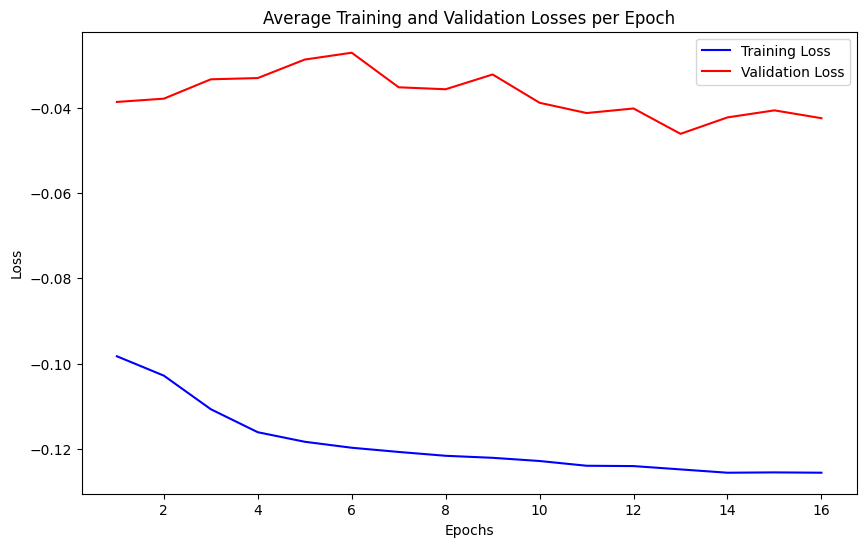

In [20]:
# Plotting train losses per epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training and Validation Losses per Epoch")
plt.legend()
plt.show()

Testing.

In [41]:
cumulative_returns_test = [1]
cumulative_returns_equal = [1] # equal
testing_data = torch.stack([torch.tensor(test_prices[1:].values, dtype=torch.float32),
                            torch.tensor(test_returns.values, dtype=torch.float32)], axis=2).to(device) # (days, S, 2)
testing_returns = torch.tensor(test_returns.values, dtype=torch.float32).to(device)

print(f"testing_data: {testing_data.shape}, testing_returns: {testing_returns.shape}")
model.eval()
with torch.no_grad():
    for t in range(T, testing_data.shape[0]):
        weights = model(testing_data[t - T:t].reshape(1, 1, T, S, 2)) # (T, S, 2) -> (S)
        weights_equal = (torch.ones(S) / S).to(device) # equal
        next_day_return = weights @ testing_returns[t]
        next_day_return_equal = weights_equal @ testing_returns[t] # equal
        cumulative_returns_test.append(cumulative_returns_test[-1] * (1 + next_day_return))
        cumulative_returns_equal.append(cumulative_returns_equal[-1] * (1 + next_day_return_equal)) # equal

testing_data: torch.Size([1107, 505, 2]), testing_returns: torch.Size([1107, 505])


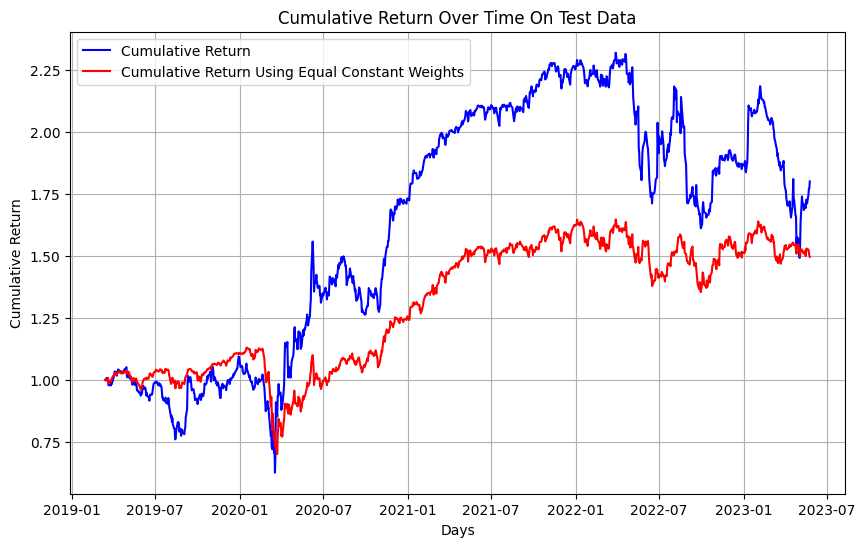

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(test_prices[1:].index.values[T - 1:], np.array([r.cpu()[0][0] if r != 1 else r for r in cumulative_returns_test]),
         label='Cumulative Return', color='blue')
plt.plot(test_prices[1:].index.values[T - 1:], np.array([r.cpu() if r != 1 else r for r in cumulative_returns_equal]),
         label='Cumulative Return Using Equal Constant Weights', color='red') # equal
plt.title("Cumulative Return Over Time On Test Data")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
print(f"Cached:    {torch.cuda.memory_reserved() / 1e9:.2f} GB")

In [ ]:
torch.cuda.empty_cache()

In [33]:
(torch.ones(S) / S)[0]

tensor(0.0020)